Experiment 1 (noise removal): The noisy image shown below (i.e., can be downloaded from course's webpage) has been generated by adding “cosine” (i.e., periodic) noise to the original image. (a) Using frequency domain filtering, use (i) a band-reject filter and (ii) a notch filter to remove the noise and show your results in each case. When presenting your results, make sure that you discuss how you chose the parameters of the filters and show the spectra for all images (before and after filtering) and filters. For comparison purposes, attempt to remove the noise in the spatial domain using Gaussian filtering (e.g., 7 x 7 or 15 x 15 filters). Compare your results between the spatial and frequency domains. (b) Instead of removing the noise pattern, devise a procedure using frequency domain filtering to extract the noise pattern and show your results. (c) Systems that perform face verification and recognition (see definitions below) can greatly benefit from high quality face image inputs. What are some possible implications on face verification and recognition performance of failing to remove/reduce noise in face images or introducing artifacts due to algorithmic errors? This is a free response question; you can discuss both safety and economic implications. Provide proper citation for any information obtained from other sources.

In [17]:
#1a

/var/folders/1c/18_hdbdx6w30l6cybmcjv74c0000gp/T/ipykernel_51635/1262978765.py:116: RuntimeWarning: divide by zero encountered in scalar divide
  H[u, v] = 1 / (1 + (d0 / D_uv)**(2*n))


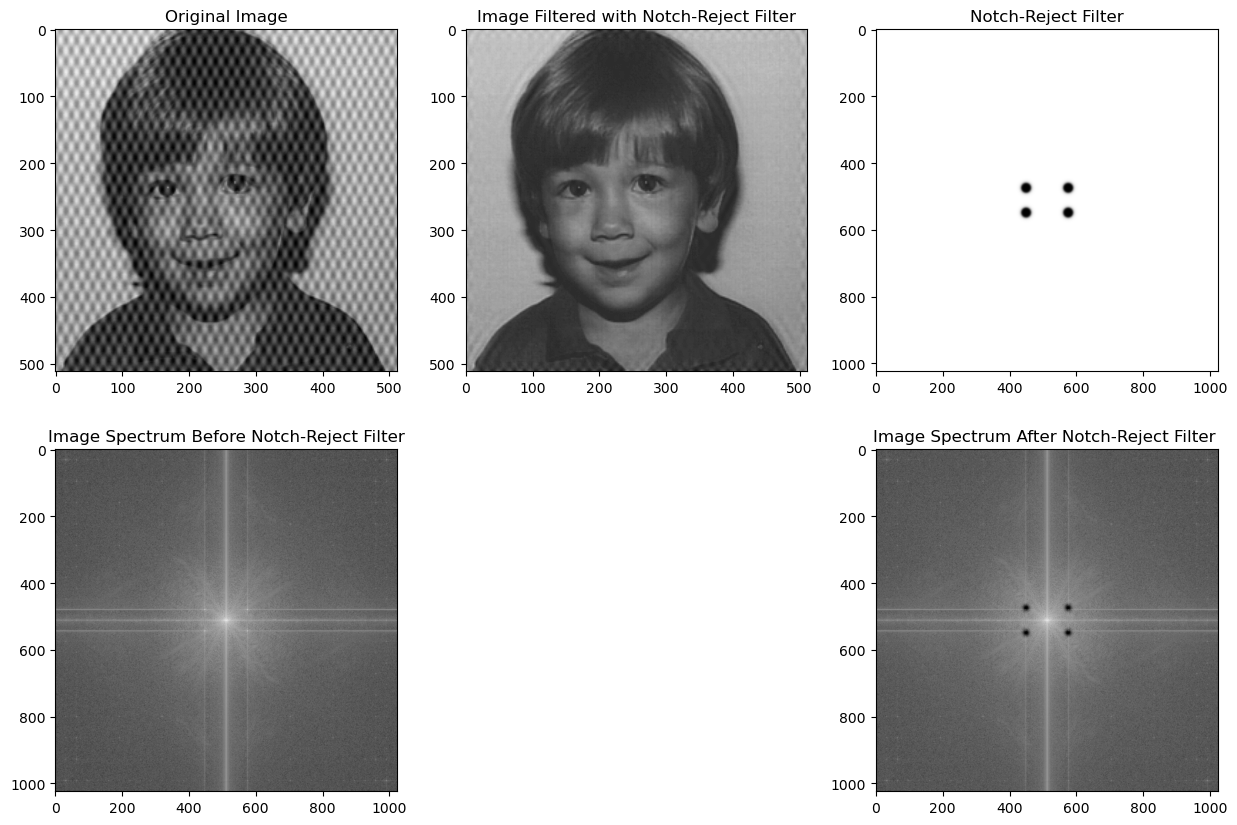

In [9]:
# Notch Reject Filter
import numpy as np
import matplotlib.pyplot as plt
import math
from skimage import io

# Inverse Discrete Fourier Transform (IDFT) Function
def idft(X):
    N = len(X)
    x = np.zeros(N, dtype=complex)

    # Compute IDFT using the formula
    for n in range(N):
        for k in range(N):
            angle = 2 * math.pi * k * n / N
            x[n] += X[k] * complex(math.cos(angle), math.sin(angle))
    return x

# 1D Discrete Fourier Transform (DFT) Function
def dft1D(x, sign):
    N = len(x)
    X = np.zeros(N, dtype=complex)

    # Compute 1D DFT using the formula
    for k in range(N):
        X[k] = np.sum(x * np.exp(sign * (-2j * np.pi * k * np.arange(N) / N)))
    
    if sign == 1:
        X /= N
    
    return X

# 2D Discrete Fourier Transform (DFT) Function
def dft2D(x, sign):
    N, M = x.shape
    result = np.zeros((N, M), dtype=complex)

    # Apply 1D DFT along each row
    for u in range(N):
        result[u, :] = dft1D(x[u, :], sign)

    # Apply 1D DFT along each column
    for v in range(M):
        result[:, v] = dft1D(result[:, v], sign)

    return result

# 2D Fast Fourier Transform (FFT) Function
def fft2(x):
    return dft2D(x, sign=-1)

# 2D Inverse Fast Fourier Transform (IFFT) Function
def ifft2(X):
    return dft2D(X, sign=1)

# Apply Frequency Filter to an image using FFT
def apply_frequency_filter(image, filter_function, filter_parameters=None):
    P, Q = 2 * image.shape[0], 2 * image.shape[1]

    # Pad the image to size 2P x 2Q
    fp = np.pad(image, ((0, P - image.shape[0]), (0, Q - image.shape[1])), 'constant', constant_values=0)
    
    # Center the padded image
    fp_centered = fp * ((-1) ** (np.arange(P).reshape(-1, 1) + np.arange(Q)))
    
    # Compute FFT of the centered image
    F = fft2(fp_centered)
    
    # Construct the specified filter
    H = construct_filter(filter_function, P, Q, filter_parameters)
    
    # Apply the filter in the frequency domain
    G = H * F
    
    # Compute the inverse FFT to obtain the filtered image
    gp = ifft2(G).real * ((-1) ** (np.arange(P).reshape(-1, 1) + np.arange(Q)))
    
    # Crop the result to the original image size
    g = gp[:image.shape[0], :image.shape[1]]
    
    return g, H, G, F

# Construct a frequency domain filter based on specified parameters
def construct_filter(filter_function, P, Q, filter_parameters=None):
    if filter_function == 'notch_reject':
        d0 = filter_parameters['d0']
        n = filter_parameters['n']
        u_k = filter_parameters['u_k']
        v_k = filter_parameters['v_k']
        circles = filter_parameters.get('circles', [])
        return notch_reject_filter((P, Q), d0=d0, n=n, u_k=u_k, v_k=v_k, circles=circles)

# Construct a notch-reject filter in the frequency domain
def notch_reject_filter(shape, d0=8, ftype='butterworth', n=4, u_k=10, v_k=20, circles=None):
    H = np.ones(shape, dtype=np.complex128)

    if circles is None:
        circles = []

    # Apply highpass filters for each specified circle
    for circle in circles:
        u_k, v_k, radius = circle
        H *= highpass_filter(shape, d0, ftype, n, u_k, v_k, radius)

    return H

# Construct a highpass filter in the frequency domain
def highpass_filter(shape, d0=8, ftype='butterworth', n=4, u_k=10, v_k=20, radius=1):
    P, Q = shape
    H = np.ones((P, Q), dtype=np.complex128)

    for u in range(0, P):
        for v in range(0, Q):
            D_uv = np.sqrt((u - (P/2) - u_k)**2 + (v - (Q/2) - v_k)**2)

            if ftype == 'butterworth':
                H[u, v] = 1 / (1 + (d0 / D_uv)**(2*n))

            # Add circular notch
            if D_uv <= radius:
                H[u, v] = 0

    return H

# Shift the zero-frequency component to the center
def fftshift(x):
    N, M = x.shape
    shift_n = N // 2
    shift_m = M // 2
    return np.roll(np.roll(x, shift_n, axis=0), shift_m, axis=1)

# Inverse shift to bring back the zero-frequency component to the corner
def ifftshift(x):
    N, M = x.shape
    shift_n = (N + 1) // 2
    shift_m = (M + 1) // 2
    return np.roll(np.roll(x, shift_n, axis=0), shift_m, axis=1)

# Load the noisy image
image_path = 'boy_noisy.gif' 
original_image = io.imread(image_path)

if original_image.ndim == 3:
    original_image = original_image[:, :, 0]

# Apply Notch-Reject Filter with four circles
notch_reject_parameters = {
    'd0': 16,
    'n': 4,
    'u_k': 37,
    'v_k': 65,
    'circles': [
        (-37, -63, 2),  
        (-37, 63, 2),  
        (37, 63, 2),   
        (37, -63, 2)    
    ]
}

# Apply the notch-reject filter and obtain filtered image and spectra
result_notch_reject, filter_spectrum_notch, fp_spectrum_, _ = apply_frequency_filter(original_image, 'notch_reject', notch_reject_parameters)

# Plotting the original image, filtered image, and spectra
plt.figure(figsize=(15, 10))

plt.subplot(231)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')

plt.subplot(232)
plt.imshow(result_notch_reject, cmap='gray', vmin=0, vmax=255)
plt.title('Image Filtered with Notch-Reject Filter')

plt.subplot(233)
plt.imshow(np.log(np.abs(filter_spectrum_notch) + 1), cmap='gray')
plt.title('Notch-Reject Filter')

plt.subplot(234)
plt.imshow(np.log(np.abs(_) + 1), cmap='gray')  
plt.title('Image Spectrum Before Notch-Reject Filter')

plt.subplot(236)
plt.imshow(np.log(np.abs(fp_spectrum_) + 1), cmap='gray')  
plt.title('Image Spectrum After Notch-Reject Filter ')

plt.show()


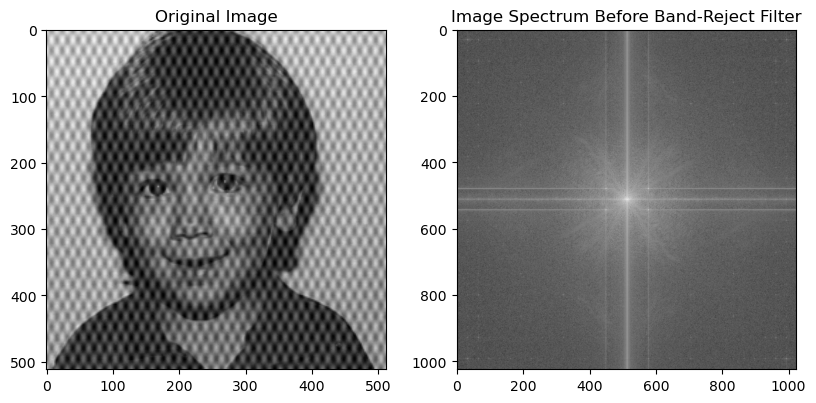

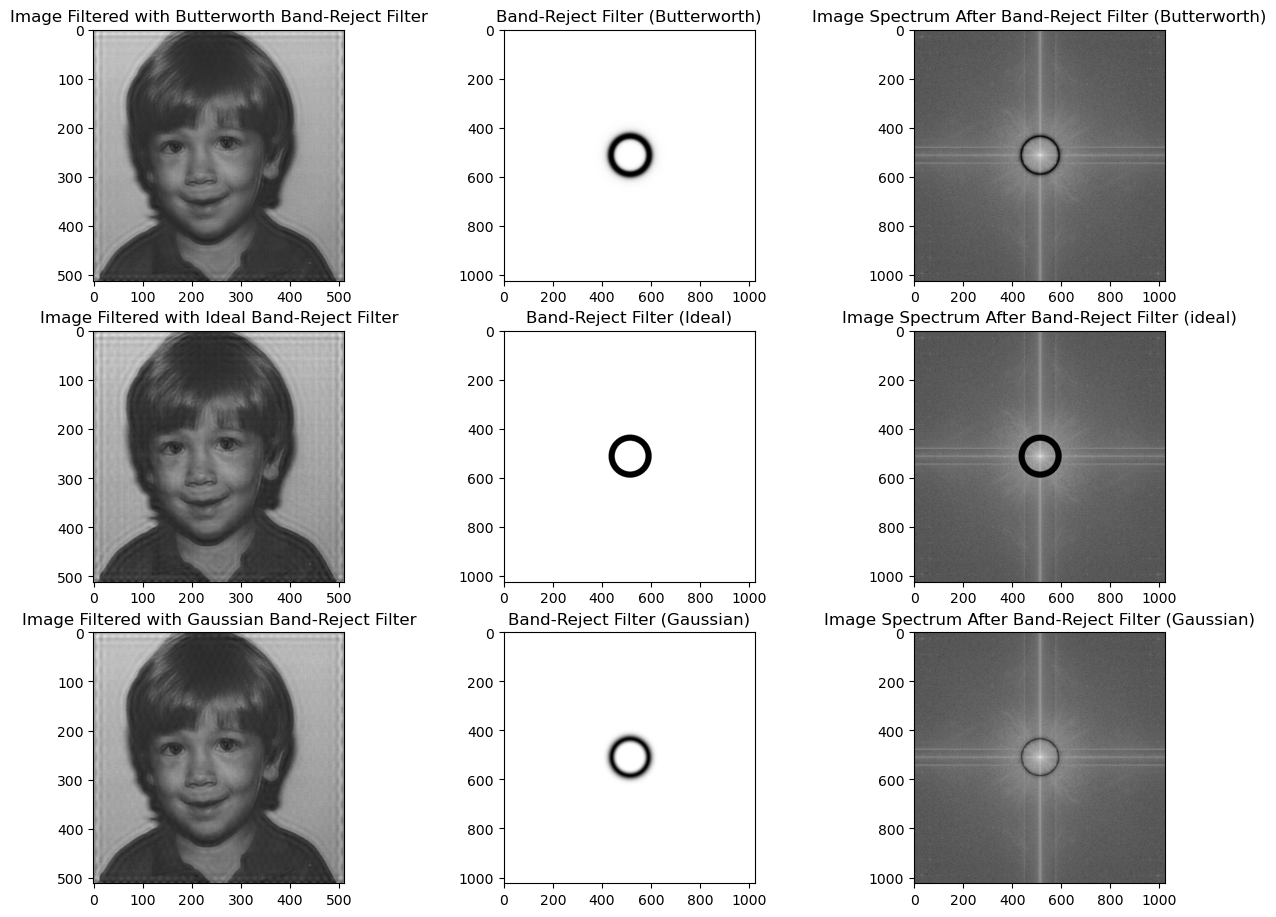

In [12]:
# Band Reject Filter
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import math 

# Inverse Discrete Fourier Transform function
def idft(X):
    N = len(X)
    x = np.zeros(N, dtype=complex)
    for n in range(N):
        for k in range(N):
            angle = 2 * math.pi * k * n / N
            x[n] += X[k] * complex(math.cos(angle), math.sin(angle))
    return x

# 1D Discrete Fourier Transform function
def dft1D(x, sign):
    N = len(x)
    X = np.zeros(N, dtype=complex)

    for k in range(N):
        X[k] = np.sum(x * np.exp(sign * (-2j * np.pi * k * np.arange(N) / N)))
    
    if sign == 1:
        X /= N
    
    return X

# 2D Discrete Fourier Transform function
def dft2D(x, sign):
    N, M = x.shape
    result = np.zeros((N, M), dtype=complex)

    for u in range(N):
        result[u, :] = dft1D(x[u, :], sign)

    for v in range(M):
        result[:, v] = dft1D(result[:, v], sign)

    return result

# 2D Fast Fourier Transform function
def fft2(x):
    return dft2D(x, sign=-1)

# 2D Inverse Fast Fourier Transform function
def ifft2(X):
    return dft2D(X, sign=1)

# Shift the zero frequency component to the center of the spectrum
def fftshift(x):
    N, M = x.shape
    shift_n = N // 2
    shift_m = M // 2
    return np.roll(np.roll(x, shift_n, axis=0), shift_m, axis=1)

# Inverse shift of the zero frequency component to the top-left corner
def ifftshift(x):
    N, M = x.shape
    shift_n = (N + 1) // 2
    shift_m = (M + 1) // 2
    return np.roll(np.roll(x, shift_n, axis=0), shift_m, axis=1)

# Apply frequency domain filter to the image
def apply_frequency_filter(image, filter_function, filter_parameters=None):
    P, Q = 2 * image.shape[0], 2 * image.shape[1]
    fp = np.pad(image, ((0, P - image.shape[0]), (0, Q - image.shape[1])), 'constant', constant_values=0)
    fp_centered = fp * ((-1) ** (np.arange(P).reshape(-1, 1) + np.arange(Q)))
    F = fft2(fp_centered)
    H = construct_filter(filter_function, P, Q, filter_parameters)
    G = H * F
    gp = ifft2(G).real * ((-1) ** (np.arange(P).reshape(-1, 1) + np.arange(Q)))
    g = gp[:image.shape[0], :image.shape[1]]
    return g, H, G, F

# Construct various frequency filters
def construct_filter(filter_function, P, Q, filter_parameters=None):
    if filter_function == 'band_reject':
        d0 = filter_parameters['d0']
        w = filter_parameters['w']
        n = filter_parameters['n']
        return bandreject_filter((P, Q), d0=d0, w=w, n=n)
    elif filter_function == 'ideal':
        d0 = filter_parameters['d0']
        w = filter_parameters['w']
        return ideal_filter((P, Q), d0=d0, w=w)
    elif filter_function == 'gaussian':
        d0 = filter_parameters['d0']
        w = filter_parameters['w']
        return gaussian_filter((P, Q), d0=d0, w=w)

# Butterworth band-reject filter
def bandreject_filter(shape, d0=160, w=20, ftype='butterworth', n=2):
    P, Q = shape
    H = np.ones((P, Q))

    for u in range(0, P):
        for v in range(0, Q):
            D_uv = np.sqrt((u - (P/2))**2 + (v - (Q/2))**2)

            if ftype == 'butterworth':
                if D_uv == d0:  # To avoid dividing by zero
                    H[u, v] = 0
                else:
                    H[u, v] = 1 / (1 + ((D_uv * w) / (D_uv**2 - d0**2))**(2 * n))
    return H

# Ideal band-reject filter
def ideal_filter(shape, d0=160, w=20):
    P, Q = shape
    H = np.ones((P, Q))

    for u in range(0, P):
        for v in range(0, Q):
            D_uv = np.sqrt((u - (P/2))**2 + (v - (Q/2))**2)

            if (d0 - (w/2)) <= D_uv <= (d0 + (w/2)):
                H[u, v] = 0.0

    return H

# Gaussian band-reject filter
def gaussian_filter(shape, d0=160, w=20):
    P, Q = shape
    H = np.ones((P, Q))

    for u in range(0, P):
        for v in range(0, Q):
            D_uv = np.sqrt((u - (P/2))**2 + (v - (Q/2))**2)

            if D_uv == 0: # To avoid dividing by zero
                H[u, v] = 1
            else:
                H[u, v] = 1.0 - np.exp(-((D_uv**2 - d0**2) / (D_uv * w))**2)

    return H

# Load the noisy image
image_path = 'boy_noisy.gif' 
original_image = io.imread(image_path)

# If the image is in color, take only one channel
if original_image.ndim == 3:
    original_image = original_image[:, :, 0]

# Parameters for the Butterworth band-reject filter
band_reject_parameters = {
    'd0': 77,
    'w': 30,
    'n': 2
}

# Apply Butterworth band-reject filter to the image
result_band_reject, filter_spectrum, fp_spectrum,_ = apply_frequency_filter(original_image, 'band_reject', band_reject_parameters)

# Parameters for the Ideal band-reject filter
ideal_parameters = {
    'd0': 75,
    'w': 25
}

# Apply Ideal band-reject filter to the image
result_ideal, filter_spectrum_ideal, fp_spectrum_ideal, __ = apply_frequency_filter(original_image, 'ideal', ideal_parameters)

# Parameters for the Gaussian band-reject filter
gaussian_parameters = {
    'd0': 75,
    'w': 30
}

# Apply Gaussian band-reject filter to the image
result_gaussian, filter_spectrum_gaussian, fp_spectrum_gaussian,___ = apply_frequency_filter(original_image, 'gaussian', gaussian_parameters)

# Plotting the results
plt.figure(figsize=(15, 15))

plt.subplot(331)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')

plt.subplot(332)
plt.imshow(np.log(np.abs(_) + 1), cmap='gray')
plt.title('Image Spectrum Before Band-Reject Filter')

plt.figure(figsize=(15, 15))
plt.subplot(431)
plt.imshow(result_band_reject, cmap='gray', vmin=0, vmax=255)
plt.title('Image Filtered with Butterworth Band-Reject Filter')

plt.subplot(432)
plt.imshow(np.log(np.abs(filter_spectrum) + 1), cmap='gray')
plt.title('Band-Reject Filter (Butterworth)')

plt.subplot(433)
plt.imshow(np.log(np.abs(fp_spectrum) + 1), cmap='gray')
plt.title('Image Spectrum After Band-Reject Filter (Butterworth)')

plt.subplot(434)
plt.imshow(result_ideal, cmap='gray', vmin=0, vmax=255)
plt.title('Image Filtered with Ideal Band-Reject Filter')

plt.subplot(435)
plt.imshow(np.log(np.abs(filter_spectrum_ideal) + 1), cmap='gray')
plt.title('Band-Reject Filter (Ideal)')

plt.subplot(436)
plt.imshow(np.log(np.abs(fp_spectrum_ideal) + 1), cmap='gray')
plt.title('Image Spectrum After Band-Reject Filter (ideal)')

plt.subplot(437)
plt.imshow(result_gaussian, cmap='gray', vmin=0, vmax=255)
plt.title('Image Filtered with Gaussian Band-Reject Filter')

plt.subplot(438)
plt.imshow(np.log(np.abs(filter_spectrum_gaussian) + 1), cmap='gray')
plt.title('Band-Reject Filter (Gaussian)')

plt.subplot(439)
plt.imshow(np.log(np.abs(fp_spectrum_gaussian) + 1), cmap='gray')
plt.title('Image Spectrum After Band-Reject Filter (Gaussian)')

plt.show()

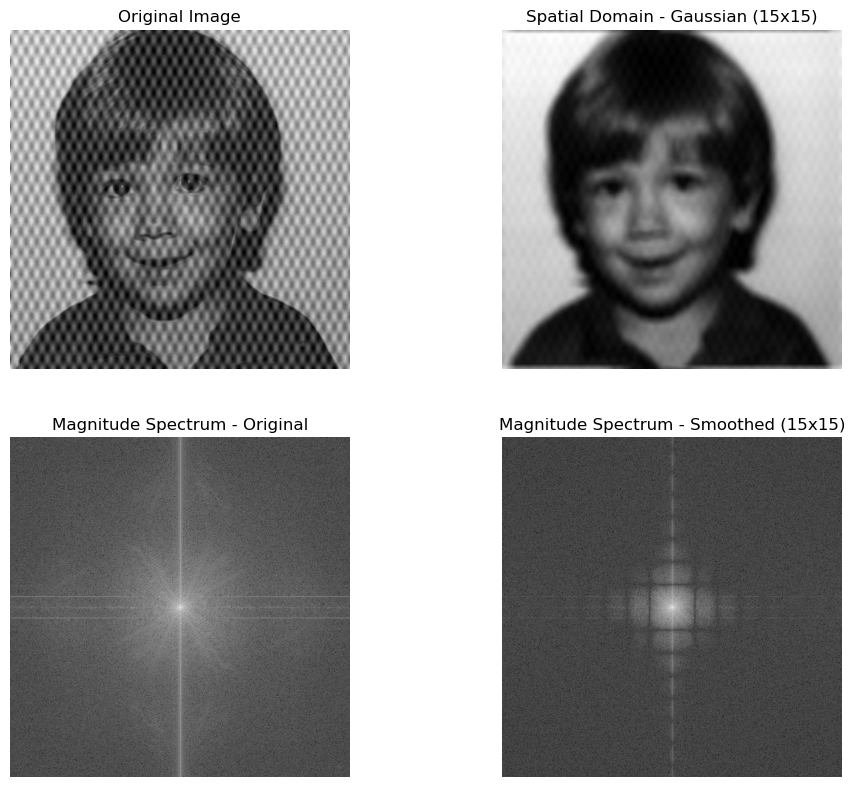

In [17]:
# Gaussian Filter
import numpy as np
import math
from matplotlib import pyplot as plt
from skimage import io

# Custom 1D Inverse Discrete Fourier Transform (IDFT) Function
def idft1D(X):
    N = len(X)
    x = np.zeros(N, dtype=complex)

    # Compute IDFT using the formula
    for n in range(N):
        for k in range(N):
            angle = 2 * math.pi * k * n / N
            x[n] += X[k] * complex(math.cos(angle), math.sin(angle))
    return x / N

# Custom 2D Inverse Discrete Fourier Transform (IDFT) Function
def idft2D(X):
    N, M = X.shape
    result = np.zeros((N, M), dtype=complex)

    # Apply 1D IDFT along each row
    for u in range(N):
        result[u, :] = idft1D(X[u, :])

    # Apply 1D IDFT along each column
    for v in range(M):
        result[:, v] = idft1D(result[:, v])

    return result

# Custom 1D Discrete Fourier Transform (DFT) Function
def dft1D(x, sign):
    N = len(x)
    X = np.zeros(N, dtype=complex)

    # Compute 1D DFT using the formula
    for k in range(N):
        X[k] = np.sum(x * np.exp(sign * (-2j * np.pi * k * np.arange(N) / N)))
    
    if sign == 1:
        X /= N
    
    return X

# Custom 2D Discrete Fourier Transform (DFT) Function
def dft2D(x, sign):
    N, M = x.shape
    result = np.zeros((N, M), dtype=complex)

    # Apply 1D DFT along each row
    for u in range(N):
        result[u, :] = dft1D(x[u, :], sign)

    # Apply 1D DFT along each column
    for v in range(M):
        result[:, v] = dft1D(result[:, v], sign)

    return result

# Custom FFT shift and IFFT shift functions
def fftshift(x):
    N, M = x.shape
    shift_n = N // 2
    shift_m = M // 2
    return np.roll(np.roll(x, shift_n, axis=0), shift_m, axis=1)

def ifftshift(x):
    N, M = x.shape
    shift_n = (N + 1) // 2
    shift_m = (M + 1) // 2
    return np.roll(np.roll(x, shift_n, axis=0), shift_m, axis=1)

# Custom Gaussian blur function
def custom_gaussian_blur(img, kernel_size, sigma):
    # Generate 1D Gaussian kernel
    kernel_1d = np.exp(-(np.arange(-kernel_size // 2, kernel_size // 2 + 1)**2) / (2 * sigma**2))
    kernel_1d /= np.sum(kernel_1d)

    # Create 2D Gaussian kernel
    kernel_2d = np.outer(kernel_1d, kernel_1d)

    # Perform convolution in the spatial domain
    blurred_img = np.zeros_like(img, dtype=float)
    N, M = img.shape
    for i in range(N):
        for j in range(M):
            for u in range(kernel_size):
                for v in range(kernel_size):
                    ii = (i + u - kernel_size // 2) % N
                    jj = (j + v - kernel_size // 2) % M
                    blurred_img[i, j] += img[ii, jj] * kernel_2d[u, v]

    return blurred_img.astype(np.uint8)

# Load the image
img_path = 'boy_noisy.gif'
img = io.imread(img_path)

spatial_kernel_size_15x15 = 15
spatial_sigma_15x15 = 65  # Adjust the standard deviation as needed
spatial_smoothed_img_15x15 = custom_gaussian_blur(img, spatial_kernel_size_15x15, spatial_sigma_15x15)

# Perform DFT on the original and both smoothed images
dft_original = dft2D(img, sign=-1)
dft_smoothed_15x15 = dft2D(spatial_smoothed_img_15x15, sign=-1)

# Apply FFT shift to the magnitude spectrum
magnitude_spectrum_original = np.log(1 + np.abs(fftshift(dft_original)))
magnitude_spectrum_smoothed_15x15 = np.log(1 + np.abs(fftshift(dft_smoothed_15x15)))

# Display the results
plt.figure(figsize=(18, 15))

plt.subplot(3, 3, 1)
plt.title('Original Image')
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(3, 3, 2)
plt.title('Spatial Domain - Gaussian (15x15)')
plt.imshow(spatial_smoothed_img_15x15, cmap='gray')
plt.axis('off')

plt.subplot(3, 3, 4)
plt.title('Magnitude Spectrum - Original')
plt.imshow(magnitude_spectrum_original, cmap='gray')
plt.axis('off')

plt.subplot(3, 3, 5)
plt.title('Magnitude Spectrum - Smoothed (15x15)')
plt.imshow(magnitude_spectrum_smoothed_15x15, cmap='gray')
plt.axis('off')

plt.show()

(b) Instead of removing the noise pattern, devise a procedure using frequency domain filtering to extract the noise pattern and show your results.

/var/folders/1c/18_hdbdx6w30l6cybmcjv74c0000gp/T/ipykernel_51635/1887828457.py:126: RuntimeWarning: invalid value encountered in scalar divide
  H[u, v] = 1 / (1 + (d0 / D_uv)**(2*n))


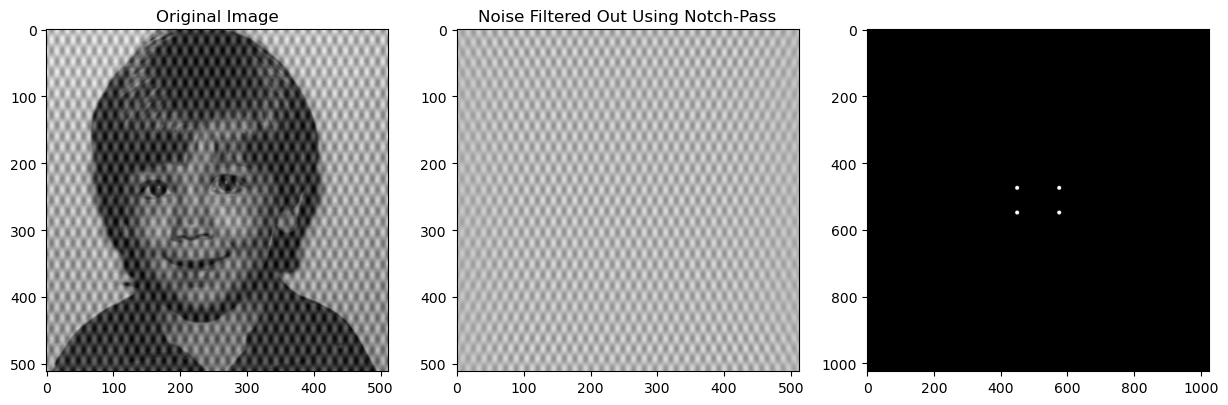

In [13]:
# Notch Pass Filter
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

# Inverse Discrete Fourier Transform function
def idft(X):
    N = len(X)
    x = np.zeros(N, dtype=complex)
    for n in range(N):
        for k in range(N):
            angle = 2 * math.pi * k * n / N
            x[n] += X[k] * complex(math.cos(angle), math.sin(angle))
    return x

# 1D Discrete Fourier Transform function
def dft1D(x, sign):
    N = len(x)
    X = np.zeros(N, dtype=complex)

    for k in range(N):
        X[k] = np.sum(x * np.exp(sign * (-2j * np.pi * k * np.arange(N) / N)))
    
    if sign == 1:
        X /= N
    
    return X

# 2D Discrete Fourier Transform function
def dft2D(x, sign):
    N, M = x.shape
    result = np.zeros((N, M), dtype=complex)

    for u in range(N):
        result[u, :] = dft1D(x[u, :], sign)

    for v in range(M):
        result[:, v] = dft1D(result[:, v], sign)

    return result

# 2D Fast Fourier Transform function
def fft2(x):
    return dft2D(x, sign=-1)

# 2D Inverse Fast Fourier Transform function
def ifft2(X):
    return dft2D(X, sign=1)

# Shift the zero frequency component to the center of the spectrum
def fftshift(x):
    N, M = x.shape
    shift_n = N // 2
    shift_m = M // 2
    return np.roll(np.roll(x, shift_n, axis=0), shift_m, axis=1)

# Inverse shift of the zero frequency component to the top-left corner
def ifftshift(x):
    N, M = x.shape
    shift_n = (N + 1) // 2
    shift_m = (M + 1) // 2
    return np.roll(np.roll(x, shift_n, axis=0), shift_m, axis=1)

def apply_frequency_filter(image, filter_function, filter_parameters=None):
    # Pad the image
    P, Q = 2 * image.shape[0], 2 * image.shape[1]
    fp = np.pad(image, ((0, P - image.shape[0]), (0, Q - image.shape[1])), 'constant', constant_values=128)  # Gray background
    fp_centered = fp * ((-1) ** (np.arange(P).reshape(-1, 1) + np.arange(Q)))
    
    # Compute 2D Fourier transform of the padded and centered image
    F = fft2(fp_centered)
    
    # Construct the specified frequency filter
    H = construct_filter(filter_function, P, Q, filter_parameters)
    
    # Apply the filter in the frequency domain
    G = H * F
    
    # Compute the inverse Fourier transform and extract the real part
    gp = ifft2(G).real * ((-1) ** (np.arange(P).reshape(-1, 1) + np.arange(Q)))
    
    # Crop the result to the original image size
    g = gp[:image.shape[0], :image.shape[1]]
    return g, H, G

def construct_filter(filter_function, P, Q, filter_parameters=None):
    # Construct the specified filter based on the chosen filter function
    if filter_function == 'notch_reject':
        d0 = filter_parameters['d0']
        n = filter_parameters['n']
        u_k = filter_parameters['u_k']
        v_k = filter_parameters['v_k']
        circles = filter_parameters['circles']
        return notch_reject_filter((P, Q), d0=d0, n=n, u_k=u_k, v_k=v_k, circles=circles)
    elif filter_function == 'notch_pass':
        d0 = filter_parameters['d0']
        n = filter_parameters['n']
        u_k = filter_parameters['u_k']
        v_k = filter_parameters['v_k']
        circles = filter_parameters['circles']
        return notch_pass_filter((P, Q), d0=d0, n=n, u_k=u_k, v_k=v_k, circles=circles)

def notch_reject_filter(shape, d0=160, n=2, u_k=0, v_k=0, circles=None):
    # Create a notch reject filter using a highpass filter
    H = highpass_filter(shape, d0, n, u_k, v_k, circles=circles)
    return H

def notch_pass_filter(shape, d0=160, n=2, u_k=0, v_k=0, circles=None):
    # Create a notch pass filter as 1 - notch reject filter
    H = 1.0 - notch_reject_filter(shape, d0, n, u_k, v_k, circles=circles)
    return H

def highpass_filter(shape, d0=8, n=4, u_k=10, v_k=20, circles=None):
    # Create a highpass filter in the frequency domain
    P, Q = shape
    H = np.ones((P, Q), dtype=np.complex128)

    for u in range(0, P):
        for v in range(0, Q):
            # Compute the distance from the center
            D_uv = np.sqrt((u - (P/2) - u_k)**2 + (v - (Q/2) - v_k)**2)

            # Compute the highpass filter response
            if n == 0:
                H[u, v] = 1 / (1 + (D_uv / d0)**(2*n))
            else:
                H[u, v] = 1 / (1 + (d0 / D_uv)**(2*n))

            # Add circular notches
            if circles is not None:
                for circle in circles:
                    u_c, v_c, radius = circle
                    D_uv_circular = np.sqrt((u - (P/2) - u_c)**2 + (v - (Q/2) - v_c)**2)
                    if D_uv_circular <= radius:
                        H[u, v] = 0

    return H

# Load the noisy image
image_path = 'boy_noisy.gif'  # replace with the actual path
original_image = io.imread(image_path)

# Assuming the image is already in grayscale, skip rgb2gray conversion
if original_image.ndim == 3:
    original_image = original_image[:, :, 0]

# Create a gray background image
gray_background = np.ones_like(original_image) * 180

# Example: Apply Notch-Pass Filter
notch_pass_parameters = {
    'd0': 0,
    'n': 4,
    'u_k': 37,
    'v_k': 65,
    'circles': [
        (-37, -63, 6),  
        (-37, 63, 6),    
        (37, 63, 6),    
        (37, -63, 6)     
    ]
}

# Apply Notch-Pass Filter
result_notch_pass, filter_spectrum_notch_pass, fp_spectrum_notch_pass = apply_frequency_filter(original_image, 'notch_pass', notch_pass_parameters)

result_overlay_gray = gray_background + result_notch_pass

plt.figure(figsize=(15, 10))

plt.subplot(231)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')

plt.subplot(232)
plt.imshow(result_overlay_gray, cmap='gray', vmin=0, vmax=255) 
plt.title('Noise Filtered Out Using Notch-Pass')

plt.subplot(233)
plt.imshow(np.log(np.abs(filter_spectrum_notch_pass) + 1), cmap='gray') 

plt.show()


/var/folders/1c/18_hdbdx6w30l6cybmcjv74c0000gp/T/ipykernel_51635/475072277.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  H[u, v] = 1 / (1 + ((D_uv * w) / (D_uv**2 - d0**2))**(2*n))


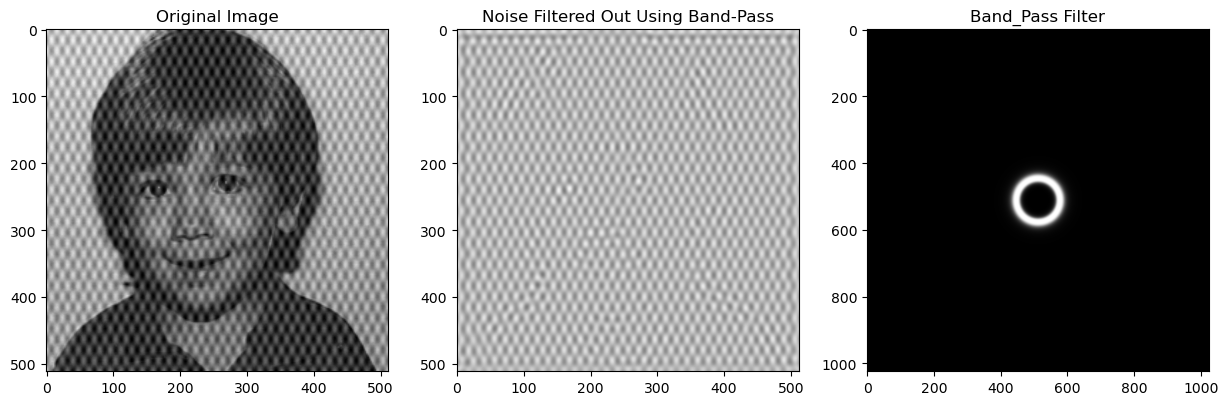

In [14]:
# Band Pass Filter
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

# Inverse Discrete Fourier Transform function
def idft(X):
    N = len(X)
    x = np.zeros(N, dtype=complex)
    for n in range(N):
        for k in range(N):
            angle = 2 * math.pi * k * n / N
            x[n] += X[k] * complex(math.cos(angle), math.sin(angle))
    return x

# 1D Discrete Fourier Transform function
def dft1D(x, sign):
    N = len(x)
    X = np.zeros(N, dtype=complex)

    for k in range(N):
        X[k] = np.sum(x * np.exp(sign * (-2j * np.pi * k * np.arange(N) / N)))
    
    if sign == 1:
        X /= N
    
    return X

# 2D Discrete Fourier Transform function
def dft2D(x, sign):
    N, M = x.shape
    result = np.zeros((N, M), dtype=complex)

    for u in range(N):
        result[u, :] = dft1D(x[u, :], sign)

    for v in range(M):
        result[:, v] = dft1D(result[:, v], sign)

    return result

# 2D Fast Fourier Transform function
def fft2(x):
    return dft2D(x, sign=-1)

# 2D Inverse Fast Fourier Transform function
def ifft2(X):
    return dft2D(X, sign=1)

# Shift the zero frequency component to the center of the spectrum
def fftshift(x):
    N, M = x.shape
    shift_n = N // 2
    shift_m = M // 2
    return np.roll(np.roll(x, shift_n, axis=0), shift_m, axis=1)

# Inverse shift of the zero frequency component to the top-left corner
def ifftshift(x):
    N, M = x.shape
    shift_n = (N + 1) // 2
    shift_m = (M + 1) // 2
    return np.roll(np.roll(x, shift_n, axis=0), shift_m, axis=1)

def apply_frequency_filter(image, filter_function, filter_parameters=None):
    # Pad the image with zeros to avoid edge artifacts
    P, Q = 2 * image.shape[0], 2 * image.shape[1]
    fp = np.pad(image, ((0, P - image.shape[0]), (0, Q - image.shape[1])), 'constant', constant_values=0)
    
    # Multiply by (-1)^(u+v) to center the frequency spectrum
    fp_centered = fp * ((-1) ** (np.arange(P).reshape(-1, 1) + np.arange(Q)))
    
    # Compute 2D Fourier transform of the padded and centered image
    F = fft2(fp_centered)
    
    # Construct the specified frequency filter
    H = construct_filter(filter_function, P, Q, filter_parameters)
    
    # Apply the filter in the frequency domain
    G = H * F
    
    # Compute the inverse Fourier transform and extract the real part
    gp = ifft2(G).real * ((-1) ** (np.arange(P).reshape(-1, 1) + np.arange(Q)))
    
    # Crop the result to the original image size
    g = gp[:image.shape[0], :image.shape[1]]
    return g, H

def construct_filter(filter_function, P, Q, filter_parameters=None):
    # Construct the specified filter based on the chosen filter function
    if filter_function == 'band_reject':
        d0 = filter_parameters['d0']
        w = filter_parameters['w']
        n = filter_parameters['n']
        return bandreject_filter((P, Q), d0=d0, w=w, n=n)
    elif filter_function == 'band_pass':
        d0 = filter_parameters['d0']
        w = filter_parameters['w']
        n = filter_parameters['n']
        return bandpass_filter((P, Q), d0=d0, w=w, n=n)

def bandreject_filter(shape, d0=160, w=20, ftype='butterworth', n=2):
    # Create a band-reject filter in the frequency domain
    P, Q = shape
    H = np.ones((P, Q), dtype=np.complex128)
    
    for u in range(0, P):
        for v in range(0, Q):
            D_uv = np.sqrt((u - (P/2))**2 + (v - (Q/2))**2)
            
            if ftype == 'butterworth':
                H[u, v] = 1 / (1 + ((D_uv * w) / (D_uv**2 - d0**2))**(2*n))
    
    return H

def bandpass_filter(shape, d0=65, w=23, ftype='butterworth', n=2):
    # Create a band-pass filter as 1 - band-reject filter
    H = 1.0 - bandreject_filter(shape, d0, w, ftype, n)
    return H

# Load the noisy image
image_path = 'boy_noisy.gif'  # replace with the actual path
original_image = io.imread(image_path)

gray_background = np.ones_like(original_image) * 180

if original_image.ndim == 3:
    original_image = original_image[:, :, 0]

# Example: Apply Band-Pass Filter
band_pass_parameters = {
    'd0': 65,
    'w': 23,
    'n': 2
}

result_band_pass, filter_spectrum = apply_frequency_filter(original_image, 'band_pass', band_pass_parameters)

result_overlay_gray = gray_background + result_band_pass

plt.figure(figsize=(15, 10))

plt.subplot(231)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')

plt.subplot(232)
plt.imshow(result_overlay_gray, cmap='gray', vmin=0, vmax=255)
plt.title('Noise Filtered Out Using Band-Pass')

plt.subplot(233)
plt.imshow(np.log(np.abs(filter_spectrum) + 1), cmap='gray')
plt.title('Band_Pass Filter')

plt.show()

Experiment 2 (convolution in the frequency domain): Repeat the experiment described in Example 4.15 (page 317), using the “lenna” image. When presenting your results, make sure that you show the spectra for all images (before and after filtering) and filters. For comparison purposes, perform the convolution both in the spatial and frequency domains (i.e., see Figure 4.38, page 319) and compare your results.

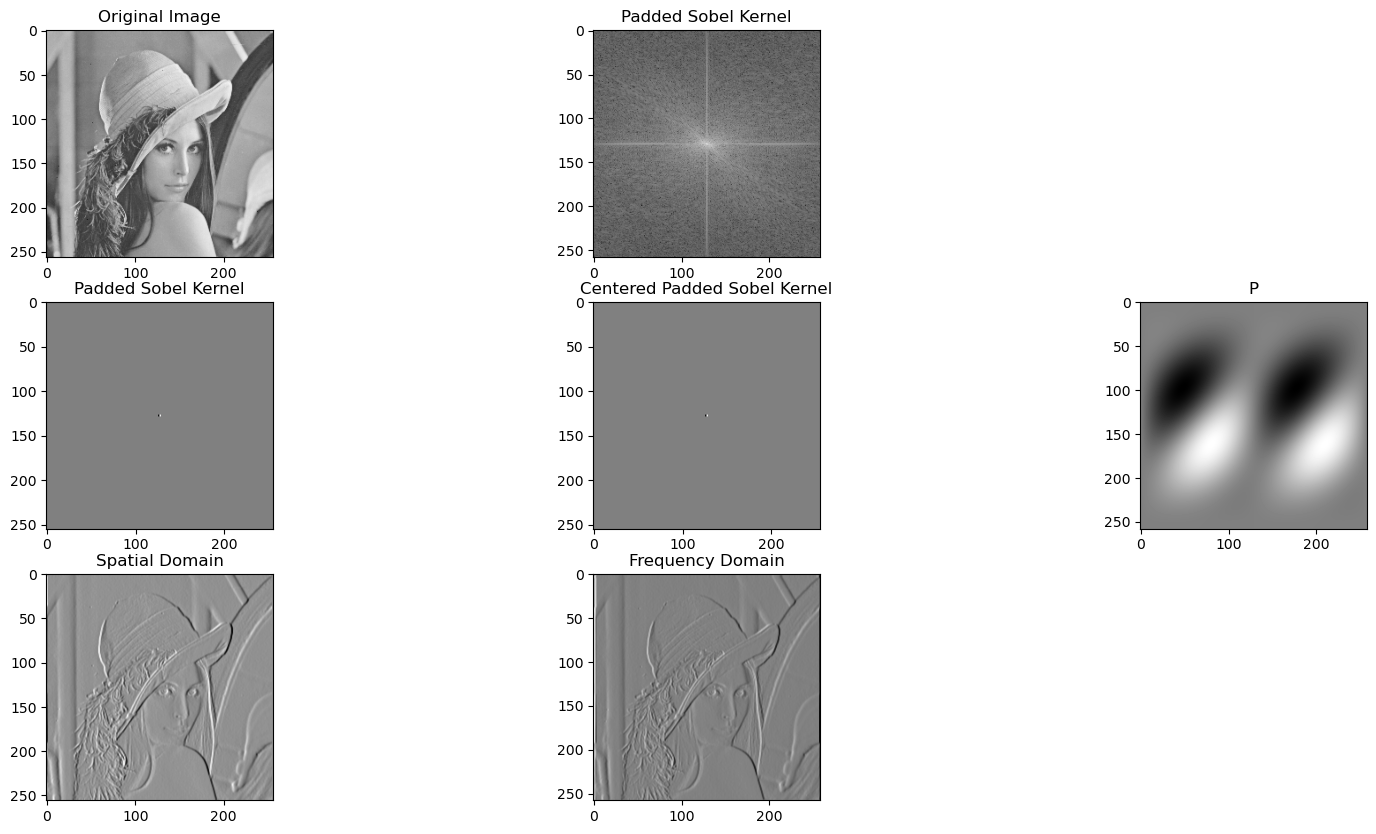

In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift

def idft(X):
    N = len(X)
    x = np.zeros(N, dtype=complex)
    for n in range(N):
        for k in range(N):
            angle = 2 * math.pi * k * n / N
            x[n] += X[k] * complex(math.cos(angle), math.sin(angle))
    return x

# DFT Function
def dft1D(x, sign):
    N = len(x)
    X = np.zeros(N, dtype=complex)

    for k in range(N):
        X[k] = np.sum(x * np.exp(sign * (-2j * np.pi * k * np.arange(N) / N)))
    
    if sign == 1:
        X /= N
    
    return X

def dft2D(x, sign):
    N, M = x.shape
    result = np.zeros((N, M), dtype=complex)

    for u in range(N):
        result[u, :] = dft1D(x[u, :], sign)

    for v in range(M):
        result[:, v] = dft1D(result[:, v], sign)

    return result

# Replace the fft2, ifft2, fftshift, and ifftshift functions
def fft2(x):
    return dft2D(x, sign=-1)

def ifft2(X):
    return dft2D(X, sign=1)

def fftshift(x):
    return np.fft.fftshift(x)

def ifftshift(x):
    return np.fft.ifftshift(x)

def apply_frequency_filter(image):
    P, Q = (image.shape[0] ), (image.shape[1] )
    fp = np.pad(image, ((0, P - image.shape[0]), (0, Q - image.shape[1])), 'constant', constant_values=0)
    fp_centered = fp * ((-1) ** (np.arange(P).reshape(-1, 1) + np.arange(Q)))
    F = fft2(fp_centered)
    
    # Ensure the size of the Sobel kernel matches the size of the Fourier-transformed image
    H = dft_sobel_kernel_shifted
    
    G = H * F
    gp = ifft2(G).real * ((-1) ** (np.arange(P).reshape(-1, 1) + np.arange(Q)))
    g = gp[:image.shape[0], :image.shape[1]]
    return g, F

# Load the Lena image
image = cv2.imread('lenna.pgm', cv2.IMREAD_GRAYSCALE)

lena_image = np.pad(image, ((1, 1), (1, 1)), mode='constant')

# Define the Sobel kernel
sobel_kernel = np.array([[1, 0, -1],
                         [2, 0, -2],
                         [1, 0, -1]])


# Pad to make both dimensions (M and N) equal to the Lena image size
sobel_kernel = np.pad(sobel_kernel, ((0, lena_image.shape[0] - 3  + 1), (0, lena_image.shape[1] - 3 + 1)), 'constant', constant_values=0)

padded_sobel_kernel = sobel_kernel[:-1, :-1]

rows, cols = padded_sobel_kernel.shape
centered_sobel_kernel = padded_sobel_kernel * np.array((-1)**(cols + rows))
dft_sobel_kernel = fft2(centered_sobel_kernel)

dft_sobel_kernel_shifted = np.fft.fftshift(dft_sobel_kernel)



fp_spectrum_, _ = apply_frequency_filter(lena_image)

sobel_kernel1 = np.array([[-1, 0, 1],
                         [-2, 0, 2],
                         [-1, 0, 1]])
# Pad the Sobel kernel with zeros to match the size of the Lena image
pad_height = (image.shape[0] - sobel_kernel1.shape[0]) // 2
pad_width = (image.shape[1] - sobel_kernel1.shape[1]) // 2

padded_sobel_kernel1 = np.pad(sobel_kernel1, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')

rows1, cols1 = padded_sobel_kernel1.shape
centered_sobel_kernel1 = padded_sobel_kernel1 * np.array((-1)**(cols1 + rows1))

convolution_result = cv2.filter2D(image, cv2.CV_64F, padded_sobel_kernel1)


# Display the results
plt.figure(figsize=(20, 10))

plt.subplot(3, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(3, 3, 2)
plt.imshow(np.log(np.abs(_) + 1), cmap='gray')
plt.title('Spectrum')
plt.subplot(3, 3, 4)
plt.imshow(padded_sobel_kernel1, cmap='gray')
plt.title('Padded Sobel Kernel')

plt.subplot(3, 3, 5)
plt.imshow(centered_sobel_kernel1, cmap='gray')
plt.title('Centered Padded Sobel Kernel')

plt.subplot(3, 3, 7)
plt.imshow(convolution_result, cmap='gray')
plt.title('Spatial Domain')


plt.subplot(3, 3, 8)
plt.imshow(fp_spectrum_, cmap='gray') 
plt.title('Frequency Domain')

plt.subplot(3, 3, 6)
plt.imshow(dft_sobel_kernel_shifted.imag, cmap='gray') 
plt.title('Transfer function shown as an image')


plt.show()

Experiment 3 (homomorphic filtering): Many times, images suffer from shading problems due to uneven illumination. The role of homomorphic filtering is to alleviate such problems. In your experiments, use the image shown below (i.e., can be downloaded from the course's webpage). As discussed in the class, the main idea behind homomorphic filtering is to separate the illumination and reflectance components by applying the logarithmic function on the image. You would then need to apply an appropriate high-pass filter, which will emphasize high frequencies and attenuate lower ones, preserving fine detail at the same time.

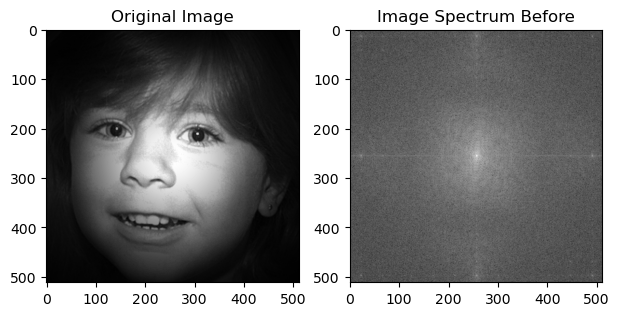

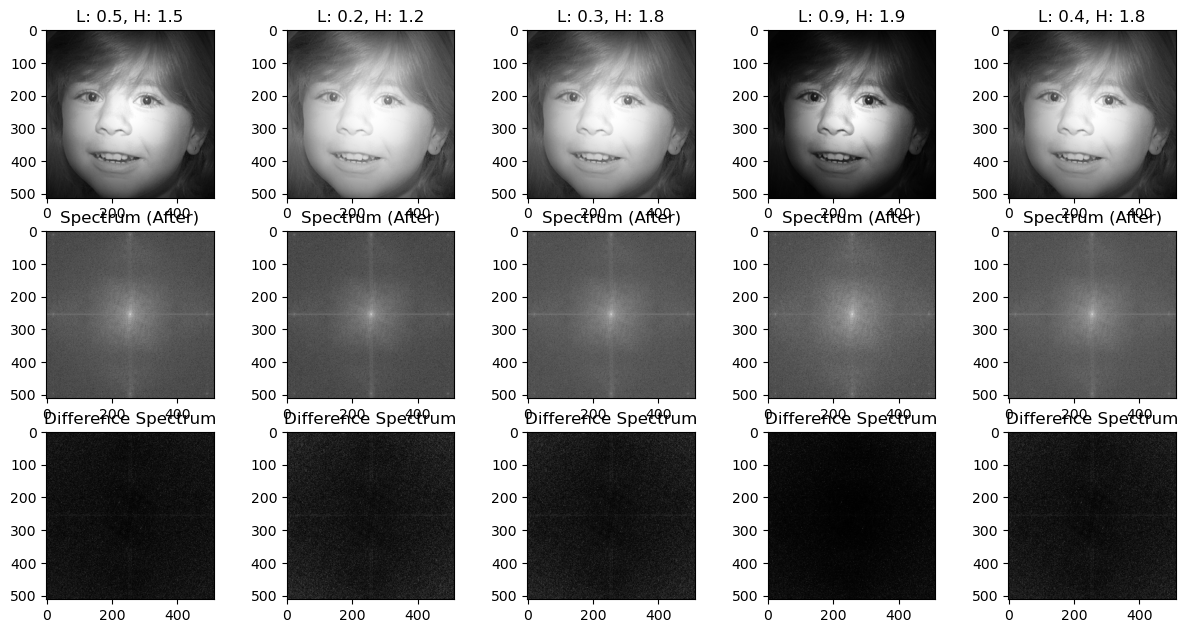

In [20]:
import cmath
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Discrete Fourier Transform (DFT) for 1D signal
def dft1D(x, sign):
    N = len(x)
    X = np.zeros(N, dtype=complex)

    for k in range(N):
        # Compute the DFT for each frequency component
        X[k] = np.sum(np.array(x) * np.array([cmath.exp(sign * (-2j * np.pi * k * i / N)) for i in range(N)]))
    
    if sign == 1:
        # Normalize for the inverse DFT
        X /= N
    
    return X

# Discrete Fourier Transform (DFT) for 2D signal
def dft2D(x, sign):
    N, M = x.shape
    result = np.zeros((N, M), dtype=complex)

    # Apply 1D DFT along rows
    for u in range(N):
        result[u, :] = dft1D(x[u, :], sign)

    # Apply 1D DFT along columns
    for v in range(M):
        result[:, v] = dft1D(result[:, v], sign)

    return result

# Fast Fourier Transform (FFT) for 2D signal
def fft2(x):
    return dft2D(x, sign=-1)

# Inverse Fast Fourier Transform (IFFT) for 2D signal
def ifft2(X):
    return dft2D(X, sign=1)

# Shift the zero-frequency component to the center
def fftshift(x):
    N, M = x.shape
    shift_n = N // 2
    shift_m = M // 2
    return np.roll(np.roll(x, shift_n, axis=0), shift_m, axis=1)

# Inverse shift to bring back the zero-frequency component to the corner
def ifftshift(x):
    N, M = x.shape
    shift_n = (N + 1) // 2
    shift_m = (M + 1) // 2
    return np.roll(np.roll(x, shift_n, axis=0), shift_m, axis=1)

# Homomorphic Filter for image enhancement
def homomorphic_filter(image, gamma_L, gamma_H, D0, c):
    # Convert the image to grayscale
    if len(image.shape) == 3:
        image = np.mean(image, axis=-1)  # Convert RGB to grayscale

    # Convert the image to float32 for processing
    image_float = np.float32(image)

    # Apply logarithmic transformation
    log_image = np.log1p(image_float)

    # Compute the 2D Fourier transform
    f_transform = dft2D(log_image, 1)

    # Create a meshgrid of frequency components
    rows, cols = image.shape
    u, v = np.meshgrid(np.fft.fftfreq(rows), np.fft.fftfreq(cols))

    # Compute the distance from the center
    D_uv = np.sqrt(u**2 + v**2)

    # High-pass filter equation
    H_uv = (gamma_H - gamma_L) * (1 - np.exp(-c * (D_uv**2 / D0**2))) + gamma_L

    # Apply the filter to the Fourier transform
    filtered_f_transform = f_transform * H_uv

    # Inverse Fourier transform to get the filtered image
    filtered_image = np.real(dft2D(filtered_f_transform, -1))

    # Exponential to revert the log transformation
    filtered_image = np.expm1(filtered_image)

    # Normalize the image
    filtered_image = np.uint8(255 * (filtered_image - np.min(filtered_image)) / np.ptp(filtered_image))

    return filtered_image, f_transform, filtered_f_transform

# Example usage
image_path = "girl.gif" 
original_image = np.array(Image.open(image_path))

filtered_image1 = homomorphic_filter(original_image, gamma_L=0.5, gamma_H=1.5, D0=1.8, c=1)

# Set five different values for gamma_L and gamma_H
gamma_values = [(0.5, 1.5), (0.2, 1.2), (0.3, 1.8), (0.9, 1.9), (0.4, 1.8)]

plt.figure(figsize=(15, 10))

plt.subplot(2, 4, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')

plt.subplot(2, 4, 2)
spectrum_original = np.log1p(np.abs(fftshift(fft2(original_image))))
plt.imshow(spectrum_original, cmap='gray')
plt.title('Image Spectrum Before')

plt.figure(figsize=(20, 10))

for i, (gamma_L, gamma_H) in enumerate(gamma_values, start=1):
    filtered_image, _, filtered_f_transform = homomorphic_filter(original_image, gamma_L, gamma_H, D0=1.8, c=1)

    plt.subplot(4, 5, i)
    plt.imshow(filtered_image, cmap='gray')
    plt.title(f'L: {gamma_L}, H: {gamma_H}')

    plt.subplot(4, 5, i + 5) 
    spectrum_filtered = np.log1p(np.abs(fftshift(fft2(filtered_image))))
    plt.imshow(spectrum_filtered, cmap='gray')
    plt.title('Spectrum (After)')
    
    plt.subplot(4, 5, i + 10)
    spectrum_difference = np.abs(spectrum_original - spectrum_filtered)
    plt.imshow(spectrum_difference, cmap='gray')
    plt.title('Difference Spectrum')
    
plt.show()
